# Flexible and Efficient Surrogate Gradient Modeling with Forward Gradient Injection
Sebastian Otte<br>Adaptive AI Lab, University of Lübeck

## Abstract

Automatic differentiation is a key feature of present deep learning frameworks.
Moreover, they typically provide various ways to specify custom gradients within
the computation graph, which is of particular importance for defining surrogate
gradients in the realms of non-differentiable operations such as the Heaviside function in spiking neural networks (SNNs). PyTorch, for example, allows the custom
specification of the backward pass of an operation by overriding its backward
method. Other frameworks provide comparable options. While these methods are
common practice and usually work well, they also have several disadvantages such
as limited flexibility, additional source code overhead, poor usability, or a potentially strong negative impact on the effectiveness of automatic model optimization
procedures. Here, an alternative way to formulate surrogate gradients is presented, namely, forward gradient injection (FGI). FGI applies a simple but effective
combination of basic standard operations to inject an arbitrary gradient shape into
the computational graph directly within the forward pass. 

## Required imports and basic functions

In [12]:
# ----------------------------------------------------------------
# Imports
# ----------------------------------------------------------------
import torch
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------------------------------------------
# Basic function
# ----------------------------------------------------------------

# Heaviside step function
def step(x : torch.Tensor) -> torch.Tensor:
    return x.gt(0.0).float()

# Gaussian function
def gaussian(x: torch.Tensor, mu: float = 0.0, sigma: float = 1.0) -> torch.Tensor:
    return torch.exp(
        -((x - mu) ** 2) / (2.0 * (sigma ** 2))
    )

# Double Gaussian function
def dblgaussian(x: torch.Tensor, 
    mu: float = 0.0, sigma1: float = 0.5, sigma2: float = 1.0,
    rel: float = 0.3
) -> torch.Tensor:
    return (
        (1 + rel) * gaussian(x, sigma=sigma1) - 
        rel * gaussian(x, sigma=sigma2)
    )

# ----------------------------------------------------------------
# For plotting
# ----------------------------------------------------------------
def to_np(x: torch.Tensor) -> np.ndarray:
    return x.detach().cpu().numpy()

def plot_dfdx(x: np.ndarray, fx: np.ndarray, dfdx: np.ndarray, title=""):
    plt.figure(figsize=(6, 3))
    plt.style.use("default")
    plt.plot(x, fx, label="y", color="xkcd:ocean blue")
    plt.plot(x, dfdx, label="x.grad", color="xkcd:scarlet")
    plt.title(title)
    plt.legend(loc="upper left")
    plt.grid()
    plt.tight_layout()
    plt.show()

## Standard way of modeling surrogate gradient functions

The standard way (in PyTorch) is overriding the backward method of a module or an autograd function as shown below.

In [10]:
class StepGaussianGrad(
    torch.autograd.Function
):
    @staticmethod
    def forward(
        ctx, x: torch.Tensor
    ) -> torch.Tensor:
        ctx.save_for_backward(x)
        return step(x)

    @staticmethod
    def backward(
        ctx, grad_output: torch.Tensor
    ) -> torch.Tensor:
        x, = ctx.saved_tensors
        dfdx = gaussian(x)
        return grad_output * dfdx

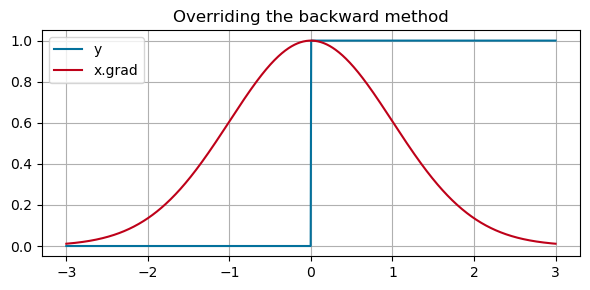

In [13]:
# Generate inputs
x = torch.linspace(-3, 3, 1000, requires_grad = True)

# Compute outputs
y = StepGaussianGrad.apply(x)

# Backprop
y.sum().backward()
dydx = x.grad

plot_dfdx(to_np(x), to_np(y), to_np(dydx), title="Overriding the backward method")

While this undergoing typically fulfills what is needed, it has several drawbacks:
- It comes with the price of a significant amount of code overhead
- If a custom gradient implementation is required on-the-fly this might disrupt the workflow, affect code readability and compatibility, and complicate model prototyping
- Moreover, this may also block framework specific builtin optimization routines, such as TorchScript

## Forward Gradient Injection

With forward gradient injection (FGI) we can model surrogate gradient functions directly inline within the forward pass.

Let $x$ be a tensor of interest, $f(x)$ an operation for which we want to substitute the gradient, and let $g'(x)$ be the shape of the desired surrogate derivative. We formulate FGI through:
$$h = x \cdot \operatorname{sg}(g'(x))$$
$$y = h − \operatorname{sg}(h) + \operatorname{sg}(f(x))$$
where $\operatorname{sg}$ is the stop gradient operator. 

- The forward pass will produce $y = f(x)$ due to out-canceling.
- When we now compute the derivative of $y$ with respect to $x$ in the backward pass we obtain: $$\frac{\partial y}{\partial x} = g'(x)$$

For details see the [paper](https://arxiv.org/pdf/2406.00177).
 
<br>
FGI in PyTorch can be realized as follows (here we to use a double Gaussian function as surrogate gradient):

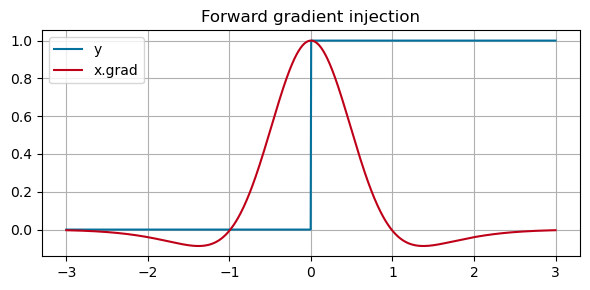

In [14]:
# Generate inputs
x = torch.linspace(-3, 3, 1000, requires_grad = True)

# Apply FGI and compute outputs:
mul = x * dblgaussian(x).detach()
y = mul - mul.detach() + step(x).detach()

# Backprop
y.sum().backward()
dydx = x.grad

plot_dfdx(to_np(x), to_np(y), to_np(dydx), title="Forward gradient injection")
